In [1]:
from fastai.vision.all import *
from fastbook import *

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
Path.BASE_PATH = path
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

In [4]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [5]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes
     

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png'),Path('train/3/10093.png'),Path('train/3/10097.png'),Path('train/3/10099.png'),Path('train/3/10116.png'),Path('train/3/10125.png'),Path('train/3/10137.png'),Path('train/3/10141.png'),Path('train/3/10144.png'),Path('train/3/10155.png'),Path('train/3/10161.png')...]

To be more specific, here are the steps that we are going to require, to turn this function into a machine learning classifier:

Initialize the weights.

For each image, use these weights to predict whether it appears to be a 3 or a 7.

Based on these predictions, calculate how good the model is (its loss).

Calculate the gradient, which measures for each weight, how changing that weight would change the loss

Step (that is, change) all the weights based on that calculation.

Go back to the step 2, and repeat the process.

Iterate until you decide to stop the training process (for instance, because the model is good enough or you don't want to wait any longer).

In [8]:

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [9]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

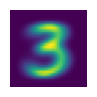

In [10]:

mean3 = stacked_threes.mean(0)
show_image(mean3);

In [11]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)


In [ ]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1) # 1 for 3, 0 for 7
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [13]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [14]:

valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [15]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [19]:
def init_params(size, std=1.0): 
    return (torch.randn(size)*std).requires_grad_() #random normal distribution to initialize weights

weights = init_params((28*28,1))
bias = init_params(1)

# In neural networks, the w in the equation y=w*x+b is called the weights, and the b is called the bias. Together, the weights and bias make up the parameters.

In [20]:
(train_x[0]*weights.T).sum() + bias

tensor([13.7164], grad_fn=<AddBackward0>)

In [ ]:
def linear1(xb): 
    return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[13.7165],
        [21.9142],
        [21.3839],
        ...,
        [ 5.1241],
        [ 9.9235],
        [10.0164]], grad_fn=<AddBackward0>)

In [ ]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [23]:
corrects.float().mean().item()

0.49249759316444397

In [24]:
with torch.no_grad(): weights[0] *= 1.0001

In [ ]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()
# A very small change in the value of a weight will often not actually change the accuracy at all. 
# This means it is not useful to use accuracy as a loss function—if we do, most of the time our gradients will actually be 0, and the model will not be able to learn from that number.

0.49249759316444397

In [27]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

The key difference is that the metric is to drive human understanding and the loss is to drive automated learning. To drive automated learning, the loss must be a function that has a meaningful derivative. It can't have big flat sections and large jumps, but instead must be reasonably smooth. This is why we designed a loss function that would respond to small changes in confidence level. This requirement means that sometimes it does not really reflect exactly what we are trying to achieve, but is rather a compromise between our real goal and a function that can be optimized using its gradient. The loss function is calculated for each item in our dataset, and then at the end of an epoch the loss values are all averaged and the overall mean is reported for the epoch.

In [28]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [29]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [30]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [31]:
preds = linear1(batch)
preds

tensor([[13.7165],
        [21.9142],
        [21.3839],
        [17.4212]], grad_fn=<AddBackward0>)

In [32]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(2.6822e-07, grad_fn=<MeanBackward0>)

In [33]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-3.8301e-08), tensor([-2.6822e-07]))

In [34]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [35]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-7.6602e-08), tensor([-5.3644e-07]))

In [36]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-1.1490e-07), tensor([-8.0466e-07]))

In [37]:
weights.grad.zero_()
bias.grad.zero_();

In [38]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [39]:
(preds>0.0).float() == train_y[:4]

tensor([[True],
        [True],
        [True],
        [True]])

In [40]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [41]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

In [42]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [43]:
validate_epoch(linear1)


0.4961

In [44]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.4991

In [45]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.812 0.8096 0.894 0.9277 0.9429 0.9541 0.9585 0.9614 0.9658 0.9682 0.9687 0.9692 0.9697 0.9702 0.9716 0.9731 0.9736 0.9746 0.9751 0.976 

In [47]:
linear_model = nn.Linear(28*28,1) # linear is init_params and linear combined
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [50]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: 
            p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: 
            p.grad = None

In [49]:
opt = BasicOptim(linear_model.parameters(), lr)

In [51]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [52]:
validate_epoch(linear_model)

0.4606

In [53]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [54]:
train_model(linear_model, 20)

0.4932 0.7349 0.8613 0.917 0.9355 0.9507 0.9565 0.9634 0.9658 0.9678 0.9702 0.9717 0.9746 0.9751 0.9761 0.977 0.9775 0.978 0.978 0.9785 

In [55]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr) # SGD is BasicOptim but better
train_model(linear_model, 20)

0.4932 0.9125 0.7246 0.8828 0.9214 0.9399 0.9521 0.9604 0.9648 0.9663 0.9687 0.9712 0.9721 0.9741 0.9751 0.9761 0.977 0.9775 0.978 0.9785 

In [56]:
dls = DataLoaders(dl, valid_dl)

In [57]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [58]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637148,0.503167,0.495584,00:00
1,0.435343,0.248319,0.776251,00:00
2,0.163249,0.163084,0.854269,00:00
3,0.073413,0.100785,0.916094,00:00
4,0.040210,0.074992,0.934249,00:00
5,0.027173,0.060641,0.949951,00:00
6,0.021765,0.051595,0.956330,00:00
7,0.019318,0.045526,0.962709,00:00
8,0.018046,0.041223,0.965653,00:00
9,0.017262,0.038028,0.967125,00:00
